# Binary Search Tests 

These are some of the tests that we did to verify that the decision boundary generated was, in fact, correctly generated. We did a similar test for the SVM classifier in the documentation notebook where we showed the red line which is the decision boundary generated by the function optimal_point(). 

Here we use logistic regression and show that the points chosen by the optimal_point() function have probabilities for each class around 50% which would show that these are, in fact, decision boundary points.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import warnings
import random
import matplotlib.pyplot as plt

random.seed(0)
warnings.filterwarnings('ignore', category=UserWarning)

import urllib.request
from urllib.request import urlopen
import ssl
import json
ssl._create_default_https_context = ssl._create_unverified_context
from dice_ml.utils import helpers  # helper functions


# Step: Import Files for Binary Search Optimal Method 

We import the necessary files needed to perform decision boundary tests. We test the generated decision boundaries for varying number of features, and we use logistic regression to ensure that the generated decision boundary aligns with the $50\%$ probabilities that we should expect for both classes.

In [ ]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from files.binary_search_optimal_point import optimal_point
from files.binary_search_optimal_point import multi_decision_boundary
from files.common_functions import convert_columns

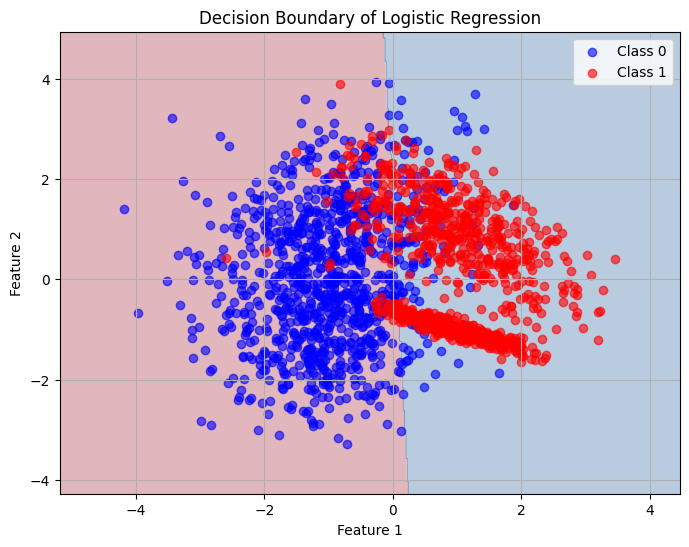

In [3]:
# Reading in the dataset
X, y = make_classification(n_samples=2000, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=2, random_state=42)
def visualize_dataset():
    clf = LogisticRegression().fit(X, y)
    # Step 2: Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                        np.linspace(y_min, y_max, 500))

    # Step 3: Predict on the grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Step 4: Plot
    plt.figure(figsize=(8, 6))

    # Decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)

    # Data points
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0', alpha=0.6)
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1', alpha=0.6)

    # Labels and title
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary of Logistic Regression')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_dataset()

In [4]:
clf = LogisticRegression()

In [5]:
def visualize_dataset():
    plt.figure(figsize=(8, 6))

    plt.scatter(X[y == 0].iloc[:, 0], X[y == 0].iloc[:, 1], color='blue', label='Class 0', alpha=0.5)
    plt.scatter(X[y == 1].iloc[:, 0], X[y == 1].iloc[:, 1], color='red', label='Class 1', alpha=0.5)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Binary Classification Data (2 Features)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
# Generate continuous features
X, y = make_classification(n_samples=1000, n_features=6, n_informative=4, n_redundant=0, random_state=42)

# Let's say first 2 features should be categorical
X_cat = np.digitize(X[:, :2], bins=[-1, 0, 1])  # turn into 3 categories
X_cont = X[:, 2:]

# Combine back
X_new = np.hstack([X_cat, X_cont])

df = pd.DataFrame(X_new, columns=[f"f{i}" for i in range(X_new.shape[1])])
df["target"] = y

In [7]:
X, y = make_classification(n_samples=2000, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=2, random_state=42)
y = y.reshape(-1,1)
df1 = pd.DataFrame(data=np.hstack((X,y)))
optimal_point(df1, model=clf, desired_class=0, original_class=1, threshold=40000, chosen_row=1, point_epsilon=1e-3, epsilon=0.01)

Class counts:
 2
1    1000
0    1000
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(40000, 2)
Finding the closest point from the contour line to the point...
Found the closest point from the contour line to the point.
[[1.01086409 1.03005092]]
[[-1.16986615 -0.05137176]]


/mnt/c/Users/Compuworld/drexel_research_2024_2025/Docs/files/common_functions.py:425: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


[np.float64(0.004523003749973498), np.float64(1.1068716308167024)]

In [ ]:
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=2, random_state=42)
model = LogisticRegression()
y = y.reshape(-1,1)
df1 = pd.DataFrame(data=np.hstack((X,y)))
x_train = df1.iloc[:,:-1]
y_train = df1.iloc[:,-1]
model.fit(x_train,y_train)

boundary_points = multi_decision_boundary(model, x_train, y_train, threshold=100000, epsilon=1e-6)

# Print the decision bo un dary points
print("Decision Boundary Points (All Features):")
print(boundary_points)
print(boundary_points.shape)

Decision Boundary Points (All Features):
              0         1
0     -2.758875  0.804341
1      0.265458 -0.042454
2      0.684222 -0.159705
3      0.435701 -0.090122
4     -0.795412  0.254585
...         ...       ...
99995  0.970861 -0.239963
99996 -1.321742  0.401954
99997 -0.744695  0.240383
99998  1.097856 -0.275520
99999 -0.915493  0.288206

[100000 rows x 2 columns]
(100000, 2)


In [9]:
preds = model.predict_proba(boundary_points)
print(np.mean(preds, axis=0))

[0.5 0.5]


In [ ]:
X, y = make_classification(n_samples=10000, n_features=10, n_informative=10,
                           n_redundant=0, n_classes=2, random_state=42)
model = LogisticRegression()
y = y.reshape(-1,1)
df2 = pd.DataFrame(data=np.hstack((X,y)))
x_train = df2.iloc[:,:-1]
y_train = df2.iloc[:,-1]
model.fit(x_train,y_train)

boundary_points = multi_decision_boundary(model, x_train, y_train, threshold=100000, epsilon=1e-6)

# Print the decision bo un dary points
print("Decision Boundary Points (All Features):")
print(boundary_points)
print(boundary_points.shape)

Decision Boundary Points (All Features):
              0         1         2         3         4         5         6  \
0      0.694830  2.271200 -0.448812  0.547791  1.575315  0.129980  0.478435   
1     -1.557300  0.874832 -0.478968 -1.496217  0.135192  1.455444  0.980312   
2     -0.266038  1.486392  0.364885 -0.652394 -0.140586 -0.656622 -0.238537   
3      0.527772 -0.537968 -1.325742 -0.670069 -0.564553  0.948859  0.149201   
4      0.325085 -0.543859  0.460457  0.169115  0.968058 -0.153377 -0.058387   
...         ...       ...       ...       ...       ...       ...       ...   
99995  3.706180 -1.219341  1.729563 -0.736579 -0.400694  2.223162  0.601644   
99996  3.974796 -0.826932 -1.304564  0.964458 -0.907511  1.435940  1.673838   
99997 -0.549406  1.459180 -0.843295  0.887195  1.446338  1.411880 -0.233887   
99998 -0.241968  0.147940  3.093540  2.323016  1.521214 -2.176957  1.434655   
99999  2.657744  0.959667 -0.178912 -2.802822 -1.306870 -0.132325 -1.171817   

          

In [11]:
preds = model.predict_proba(boundary_points)
print(np.mean(preds, axis=0))

[0.5 0.5]


In [ ]:
X, y = make_classification(n_samples=5000, n_features=51, n_informative=51, n_redundant=0, random_state=42, n_classes=2)
model = LogisticRegression()
y = y.reshape(-1,1)
df3 = pd.DataFrame(data=np.hstack((X,y)))
x_train = df3.iloc[:,:-1]
y_train = df3.iloc[:,-1]
model.fit(x_train,y_train)

boundary_points = multi_decision_boundary(model, x_train, y_train, threshold=100000, epsilon=1e-6)

# Print the decision bo un dary points
print("Decision Boundary Points (All Features):")
print(boundary_points)
print(boundary_points.shape)

Decision Boundary Points (All Features):
             0         1         2         3         4         5         6   \
0      1.088554  5.743039 -1.586188  1.985930  5.042305  0.202735 -0.063193   
1      0.144904  4.721033  2.211909  3.858976 -3.272297 -4.400448 -3.760872   
2      7.267780  2.444492 -0.964866  0.742726 -0.019744 -0.427595  0.525532   
3      0.362043 -0.506444  0.614878 -2.495079 -1.708178  0.576358 -2.445635   
4     -3.470926 -1.015413  1.396358  1.774292 -7.909722  1.107513 -0.953306   
...         ...       ...       ...       ...       ...       ...       ...   
99995 -2.167059  3.601655 -0.510168  2.953498  1.540066 -1.467379 -1.772644   
99996 -3.861032  1.473635 -3.655128 -6.415036 -1.556171  4.571603 -3.687847   
99997  3.025412 -2.035955 -2.381549  4.217858 -0.154893 -4.271483 -0.904735   
99998  4.772374 -2.882752  1.047207 -3.179967 -2.728361  1.403851  0.742569   
99999 -0.246228  4.607975  2.995905 -2.804821 -1.110446 -4.919182 -3.179313   

          

In [13]:
preds = model.predict_proba(boundary_points)
print(np.mean(preds, axis=0))

[0.5 0.5]


In [ ]:
dataset = helpers.load_adult_income_dataset()
# Generate continuous features
print(dataset)
x_train = dataset.iloc[:,:-1]
y_train = dataset.iloc[:,-1]
model = LogisticRegression()
convert_columns(x_train)
print(x_train)
model.fit(x_train,y_train)
boundary_points = multi_decision_boundary(model, x_train, y_train, threshold=100000, epsilon=1e-3)

# Print the decision bo un dary points
print("Decision Boundary Points (All Features):")
print(boundary_points)
print(boundary_points.shape)

/home/danielsin/miniconda3/envs/gpu_env/lib/python3.12/site-packages/dice_ml/utils/helpers.py:79: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adult_data = adult_data.replace({'income': {'<=50K': 0, '>50K': 1}})


       age      workclass     education marital_status    occupation   race  \
0       28        Private     Bachelors         Single  White-Collar  White   
1       30  Self-Employed         Assoc        Married  Professional  White   
2       32        Private  Some-college        Married  White-Collar  White   
3       20        Private  Some-college         Single       Service  White   
4       41  Self-Employed  Some-college        Married  White-Collar  White   
...    ...            ...           ...            ...           ...    ...   
26043   28        Private       HS-grad        Married  White-Collar  White   
26044   18        Private        School         Single   Blue-Collar  White   
26045   22        Private  Some-college         Single  White-Collar  White   
26046   42  Self-Employed     Bachelors       Divorced  White-Collar  Other   
26047   23        Private  Some-college       Divorced  White-Collar  White   

       gender  hours_per_week  income  
0      Fema

In [15]:
preds = model.predict_proba(boundary_points)
print(np.mean(preds, axis=0))

[0.50000032 0.49999968]


In [ ]:
heart_disease = pd.read_csv(
'../../heart.csv'
)
x_train = dataset.iloc[:,:-1]
y_train = dataset.iloc[:,-1]
model = LogisticRegression()
convert_columns(x_train)
print(x_train)
model.fit(x_train,y_train)
boundary_points = multi_decision_boundary(model, x_train, y_train, threshold=100000, epsilon=0.001)

# Print the decision bo un dary points
print("Decision Boundary Points (All Features):")
print(boundary_points)
print(boundary_points.shape)

        age  workclass  education  marital_status  occupation  race  gender  \
0      28.0          2          1               3           5     1       0   
1      30.0          3          0               1           2     1       1   
2      32.0          2          7               1           5     1       1   
3      20.0          2          7               3           4     1       0   
4      41.0          3          7               1           5     1       1   
...     ...        ...        ...             ...         ...   ...     ...   
26043  28.0          2          3               1           5     1       1   
26044  18.0          2          6               3           0     1       1   
26045  22.0          2          7               3           5     1       0   
26046  42.0          3          1               0           5     0       1   
26047  23.0          2          7               0           5     1       1   

       hours_per_week  
0                60.0  
1  

In [17]:
preds = model.predict_proba(boundary_points)
print(np.mean(preds, axis=0))

[0.50000048 0.49999952]
